In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping  # used for convergence criteria
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Three function are defined below to create tables and graphs. These will make the comparison between models simple. 

def create_metric_table(models, train_history,changes,version_number):
    # Create a dataframe to store the model performance metrics
    metrics = pd.DataFrame(columns=["Model", "Optimizer", "Loss Function", "Learning Rate", "Num Hidden Layers", "Num Nodes per Layer", "Train Loss", "Val Loss", "Train Acc", "Val Acc"])

    # iterates through each model and retrieve its respective performance metric
    for i, model in enumerate(models): # enumerate function helps retrieve the model and its index
        optimizer = str(model.optimizer.__class__.__name__)
        loss_function = str(model.loss)
        α = model.optimizer.lr.numpy()
        num_hidden_layers = len(model.layers) - 2 # Subtracting input and output layers
        num_nodes_per_layer = [layer.output_shape[1] for layer in model.layers if hasattr(layer, 'output_shape')]
        train_loss = train_history[i].history["loss"][-1]
        val_loss = train_history[i].history["val_loss"][-1]
        train_acc = train_history[i].history["accuracy"][-1]
        val_acc = train_history[i].history["val_accuracy"][-1]
        
        # this adds the performance metrics (gathered above) to the metrics dataframe
        metrics.loc[i] = [f"Model {i+1}", optimizer, loss_function, α, num_hidden_layers, num_nodes_per_layer, train_loss, val_loss, train_acc, val_acc]

    print(f"\nModel Performance Metrics for {changes}:")
    
    # Saving the dataframe to a csv file in Google Drive (for the report)
    folder_path = "/content/drive/MyDrive/model_comparisons"
    file_name = f"metrics{version_number}.csv"
    file_path = folder_path + "/" + file_name
    metrics.to_csv(file_path, index=False)
    return metrics

def create_graphs(train_history,version_number):

    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple']
# STOPPED HERE
    # Plotting the model for training and validation loss
    plt.figure(figsize=(10, 5))
    for i, history in enumerate(train_history):
        plt.plot(history.history["loss"], color=colors[i], label=f"Model {i+1} Train Loss")
        plt.plot(history.history["val_loss"], '--', color=colors[i], label=f"Model {i+1} Val Loss")
    plt.title("Model Loss Comparison")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(ncol=2,fontsize='small')
    folder_path = "/content/drive/MyDrive/model_comparisons"
    file_name = f"loss{version_number}.png"
    file_path = folder_path + "/" + file_name
    plt.savefig(file_path, dpi=300)
    plt.show()
    plt.show()

    # plotting the model for training and validation accuracy.
    plt.figure(figsize=(10, 5))
    for i, history in enumerate(train_history):
        plt.plot(history.history["accuracy"], color=colors[i], label=f"Model {i+1} Train Acc")
        plt.plot(history.history["val_accuracy"], '--', color=colors[i], label=f"Model {i+1} Val Acc")
    plt.title("Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(ncol=2,fontsize='small')
    #saving the graph in Google Drive
    file_name = f"accuracy{version_number}.png"
    file_path = folder_path + "/" + file_name
    plt.savefig(file_path, dpi=300)
    plt.show()

def compare_models(models, train_history,changes):
    version_number = '-'
    version_number += input('Please provide version number and change done')
    # create the table
    metric_table = create_metric_table(models, train_history,changes,version_number)
    print('')
    # Create the graphs.
    create_graphs(train_history,version_number)
    return metric_table

In [8]:
csv_file = "/content/drive/My Drive/Dataset/HIGGS_train.csv"  # path to csv

# Defining column names, Loading data
column_names = ["outcome"] + ["feature "+str(i) for i in range(1,29)]
df = pd.read_csv(csv_file, header=None, names=column_names)

<ipython-input-8-167241cbd6c8>:5: DtypeWarning: Columns (8,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, header=None, names=column_names)


In [9]:
# converting strings to float and removing rows with nan values. (pre-processing)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()

In [10]:
# The code below is used to create a tensorflow dataframe with the training data. Prior to using this dataframe, the RAM would constantly overflow. With this dataframe, however,
# the RAM is far from overflowing. 

from sklearn.preprocessing import StandardScaler

train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(0.6*len(df)), int(0.8*len(df))]) #splitting the data

#assuming the output variable is in the first column
X_train = train_df.iloc[:, 1:]
y_train = train_df.iloc[:, 0]
X_val = val_df.iloc[:, 1:]
y_val = val_df.iloc[:, 0]
X_test = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, 0]

scaler = StandardScaler()
# Fit and transform the input features for each dataset
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)  

# Create tensors from the previous partitions
train_labels = tf.constant(y_train.values)
train_features = tf.constant(X_train_scaled)
val_labels = tf.constant(y_val.values)
val_features = tf.constant(X_val_scaled)
test_labels = tf.constant(y_test.values)
test_features = tf.constant(X_test_scaled)

# Create TensorFlow datasets from the data (features are 1 column, train labels are the other column)
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))

#shuffling and batching the data.
batch_size = 32
train_buffer_size = tf.data.experimental.cardinality(train_dataset).numpy()   # setting buffer of the shuffle function to the maximum number of elements in the respective dataframe
val_buffer_size = tf.data.experimental.cardinality(val_dataset).numpy()
test_buffer_size = tf.data.experimental.cardinality(test_dataset).numpy()

train_dataset = train_dataset.shuffle(buffer_size=train_buffer_size)
train_dataset = train_dataset.batch(batch_size=batch_size)  # in this dataset, every element is a batch, which makes the code memory efficient

val_dataset = val_dataset.shuffle(buffer_size=val_buffer_size)
val_dataset = val_dataset.batch(batch_size=batch_size)

test_dataset = test_dataset.shuffle(buffer_size=test_buffer_size)
test_dataset = test_dataset.batch(batch_size=batch_size)

# prefetching the data that will be used after the current one. 
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  #tf.data.AUTOTUNE allows tensorflow to automatically determine the right amount of buffer size for prefetch
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
num_elements = tf.data.experimental.cardinality(train_dataset).numpy()

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.regularizers import L2

# Hyperparameters
l2_lambda = 0.001

# First model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=L2(l2_lambda))
])

optimizer_diff_learn_rate = Adam(learning_rate=0.001)

model_1.compile(optimizer=optimizer_diff_learn_rate, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

output_model1 = model_1.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[early_stopping])


Epoch 1/20
11250/11250 [==============================] - 63s 5ms/step - loss: 0.6164 - accuracy: 0.6925 - val_loss: 0.5814 - val_accuracy: 0.7148
Epoch 2/20
11250/11250 [==============================] - 60s 5ms/step - loss: 0.5794 - accuracy: 0.7158 - val_loss: 0.5757 - val_accuracy: 0.7196
Epoch 3/20
11250/11250 [==============================] - 52s 5ms/step - loss: 0.5741 - accuracy: 0.7204 - val_loss: 0.5716 - val_accuracy: 0.7223
Epoch 4/20
11250/11250 [==============================] - 53s 5ms/step - loss: 0.5722 - accuracy: 0.7215 - val_loss: 0.5705 - val_accuracy: 0.7254
Epoch 5/20
11250/11250 [==============================] - 52s 5ms/step - loss: 0.5708 - accuracy: 0.7228 - val_loss: 0.5683 - val_accuracy: 0.7266
Epoch 6/20
11250/11250 [==============================] - 53s 5ms/step - loss: 0.5703 - accuracy: 0.7236 - val_loss: 0.5680 - val_accuracy: 0.7255
Epoch 7/20
11250/11250 [==============================] - 62s 5ms/step - loss: 0.5702 - accuracy: 0.7235 - val_loss: 0

In [ ]:
# Hyperparameters
l2_lambda = 0.001

# Third model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=L2(l2_lambda))
])

optimizer_diff_learn_rate = Adam(learning_rate=0.001)

model_3.compile(optimizer=optimizer_diff_learn_rate, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

output_model3 = model_3.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[early_stopping])

Epoch 1/20
11250/11250 [==============================] - 55s 5ms/step - loss: 0.6155 - accuracy: 0.6951 - val_loss: 0.5839 - val_accuracy: 0.7127
Epoch 2/20
11250/11250 [==============================] - 53s 5ms/step - loss: 0.5784 - accuracy: 0.7157 - val_loss: 0.5811 - val_accuracy: 0.7135
Epoch 3/20
11250/11250 [==============================] - 52s 5ms/step - loss: 0.5734 - accuracy: 0.7203 - val_loss: 0.5732 - val_accuracy: 0.7207
Epoch 4/20
11250/11250 [==============================] - 53s 5ms/step - loss: 0.5714 - accuracy: 0.7221 - val_loss: 0.5733 - val_accuracy: 0.7207
Epoch 5/20
11250/11250 [==============================] - 53s 5ms/step - loss: 0.5700 - accuracy: 0.7232 - val_loss: 0.5732 - val_accuracy: 0.7205
Epoch 6/20
11250/11250 [==============================] - 56s 5ms/step - loss: 0.5696 - accuracy: 0.7243 - val_loss: 0.5676 - val_accuracy: 0.7263
Epoch 7/20
11250/11250 [==============================] - 53s 5ms/step - loss: 0.5690 - accuracy: 0.7251 - val_loss: 0

In [ ]:
# second model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=L2(l2_lambda))
])
optimizer_diff_learn_rate = Adam(learning_rate=0.001)

model_2.compile(optimizer=optimizer_diff_learn_rate, loss='binary_crossentropy', metrics=['accuracy'])

#early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

#output_model2 = model_2.fit(train_dataset, validation_data=val_dataset, epochs=10,callbacks=[early_stopping])

In [ ]:
# fourth model
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=L2(l2_lambda))
])
optimizer_diff_learn_rate = Adam(learning_rate=0.001)

model_4.compile(optimizer=optimizer_diff_learn_rate, loss='binary_crossentropy', metrics=['accuracy'])


#early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

output_model4 = model_4.fit(train_dataset, validation_data=val_dataset, epochs=20,callbacks=[early_stopping])

Epoch 1/20
11250/11250 [==============================] - 93s 8ms/step - loss: 0.6981 - accuracy: 0.5294 - val_loss: 0.6914 - val_accuracy: 0.5292
Epoch 2/20
11250/11250 [==============================] - 85s 8ms/step - loss: 0.6915 - accuracy: 0.5294 - val_loss: 0.6914 - val_accuracy: 0.5292
Epoch 3/20
11250/11250 [==============================] - 86s 8ms/step - loss: 0.6915 - accuracy: 0.5294 - val_loss: 0.6914 - val_accuracy: 0.5292
Epoch 4/20
11250/11250 [==============================] - 86s 8ms/step - loss: 0.6915 - accuracy: 0.5294 - val_loss: 0.6915 - val_accuracy: 0.5292
Epoch 5/20
11250/11250 [==============================] - 84s 7ms/step - loss: 0.6914 - accuracy: 0.5294 - val_loss: 0.6914 - val_accuracy: 0.5292
Epoch 6/20
11250/11250 [==============================] - 83s 7ms/step - loss: 0.6914 - accuracy: 0.5294 - val_loss: 0.6915 - val_accuracy: 0.5292


In [ ]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=L2(l2_lambda)),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=L2(l2_lambda))
])
optimizer_diff_learn_rate = Adam(learning_rate=0.001)

model_5.compile(optimizer=optimizer_diff_learn_rate, loss='binary_crossentropy', metrics=['accuracy'])

#early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

output_model5 = model_5.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[early_stopping])


Epoch 1/20
11246/11250 [============================>.] - ETA: 0s - loss: 0.6146 - accuracy: 0.6941

In [12]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5)



output_model5 = model_5.fit(train_dataset, 
                            validation_data=val_dataset, 
                            epochs=30, 
                            callbacks=[early_stopping],
                            batch_size=64)

Epoch 1/30
11250/11250 [==============================] - 73s 6ms/step - loss: 0.5666 - accuracy: 0.7023 - val_loss: 0.5423 - val_accuracy: 0.7235
Epoch 2/30
11250/11250 [==============================] - 60s 5ms/step - loss: 0.5337 - accuracy: 0.7274 - val_loss: 0.5283 - val_accuracy: 0.7307
Epoch 3/30
11250/11250 [==============================] - 64s 6ms/step - loss: 0.5211 - accuracy: 0.7364 - val_loss: 0.5193 - val_accuracy: 0.7393
Epoch 4/30
11250/11250 [==============================] - 60s 5ms/step - loss: 0.5141 - accuracy: 0.7410 - val_loss: 0.5198 - val_accuracy: 0.7389
Epoch 5/30
11250/11250 [==============================] - 60s 5ms/step - loss: 0.5084 - accuracy: 0.7446 - val_loss: 0.5136 - val_accuracy: 0.7416
Epoch 6/30
11250/11250 [==============================] - 59s 5ms/step - loss: 0.5042 - accuracy: 0.7472 - val_loss: 0.5090 - val_accuracy: 0.7458
Epoch 7/30
11250/11250 [==============================] - 62s 5ms/step - loss: 0.5004 - accuracy: 0.7495 - val_loss: 0

In [ ]:
list_models = [model_1,model_3]
list_output_models = [output_model1, output_model3]

NameError: ignored

In [ ]:
def dataset_to_numpy(dataset):
    features = []
    labels = []
    for x, y in dataset.unbatch().as_numpy_iterator():
        features.append(x)
        labels.append(y)
    return np.array(features), np.array(labels)


# Convert the train_dataset to NumPy arrays
X_train, y_train = dataset_to_numpy(train_dataset)

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define your neural network model in a separate function
def create_model(optimizer='adam', neurons_layer1=64, neurons_layer2=32):
    model = Sequential()
    model.add(Dense(neurons_layer1, input_shape=(28,))) # Adjust input shape based on number of features
    model.add(Dense(neurons_layer2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model




# Instantiate the custom classifier
clf = KerasClassifier(build_fn=create_model, epochs=10, verbose=0)

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'neurons_layer1': [64, 128, 256],
    'neurons_layer2': [32, 64, 128],
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train) # Pass the NumPy arrays

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


<ipython-input-17-343a6cde8e8f>:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(build_fn=create_model, epochs=10, verbose=0)


Best: 0.640589 using {'neurons_layer1': 64, 'neurons_layer2': 64}


In [ ]:


def create_model(neurons_layer1=128, learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons_layer1, activation='relu', input_shape=(28,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model







# Instantiate the custom classifier
clf = KerasClassifier(build_fn=create_model, epochs=10, verbose=0)

# Define the hyperparameter grid for GridSearchCV
param_grid = {

    'batch_size': [32, 64, 128],


}
grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train) 


<ipython-input-13-be0ebc8e974d>:27: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(build_fn=create_model, epochs=10, verbose=0)


In [ ]:
print("Best parameters found: ", grid_result.best_params_)
print("Best accuracy score found: ", grid_result.best_score_)

Best parameters found:  {'batch_size': 32, 'epochs': 10, 'learning_rate': 0.001}
Best accuracy score found:  0.7382255991299947


Please provide version number and change doneL2-Regularization

Model Performance Metrics for L2 Regularization:



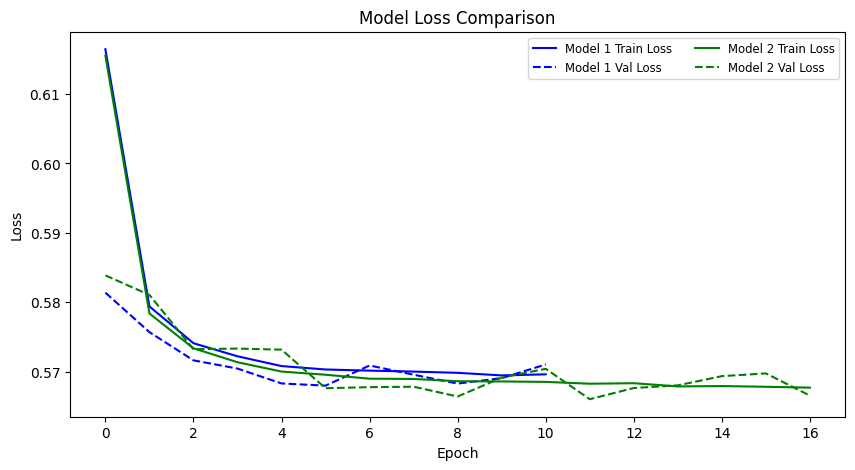

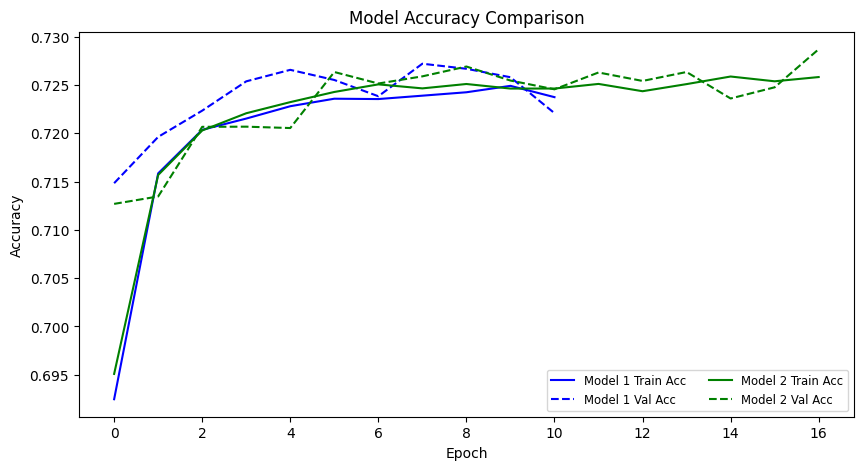

,Model,Optimizer,Loss Function,Learning Rate,Num Hidden Layers,Num Nodes per Layer,Train Loss,Val Loss,Train Acc,Val Acc
0,Model 1,Adam,binary_crossentropy,0.001,3,"[64, 128, 128, 32, 1]",0.569633,0.571053,0.723737,0.722081
1,Model 2,Adam,binary_crossentropy,0.001,3,"[256, 128, 64, 32, 1]",0.567716,0.566570,0.725817,0.728698


In [ ]:
compare_models(list_models, list_output_models, "L2 Regularization")

In [ ]:
# testing for accuracy 
loss, accuracy = model_1.evaluate(test_dataset)

print("Test loss:", loss)
print("Test accuracy:", accuracy)


3750/3750 [==============================] - 8s 2ms/step - loss: 0.7042 - accuracy: 0.5059
Test loss: 0.7041730880737305
Test accuracy: 0.5059000253677368


Auto Encoder

In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

input_dim = 28  # Input dimension for CSV data

# Encoder
input_data = Input(shape=(input_dim,))
encodes_data = Dense(14, activation='relu')(input_data)
encodes_data = Dense(7, activation='relu')(encodes_data)

# Decoder
decode_data = Dense(14, activation='relu')(encodes_data)
decode_data = Dense(input_dim, activation='sigmoid')(encodes_data)

# Autoencoder
autoencoder = Model(input_data, decode_data)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(train_dataset, epochs=10, validation_data=val_dataset)


Epoch 1/10
11250/11250 [==============================] - 45s 4ms/step - loss: 0.2067 - val_loss: 0.1944
Epoch 2/10
11250/11250 [==============================] - 41s 4ms/step - loss: 0.1918 - val_loss: 0.1893
Epoch 3/10
11250/11250 [==============================] - 41s 4ms/step - loss: 0.1886 - val_loss: 0.1880
Epoch 4/10
11250/11250 [==============================] - 42s 4ms/step - loss: 0.1868 - val_loss: 0.1857
Epoch 5/10
11250/11250 [==============================] - 47s 4ms/step - loss: 0.1856 - val_loss: 0.1848
Epoch 6/10
11250/11250 [==============================] - 58s 5ms/step - loss: 0.1847 - val_loss: 0.1847
Epoch 7/10
11250/11250 [==============================] - 41s 4ms/step - loss: 0.1840 - val_loss: 0.1838
Epoch 8/10
11250/11250 [==============================] - 42s 4ms/step - loss: 0.1834 - val_loss: 0.1829
Epoch 9/10
11250/11250 [==============================] - 48s 4ms/step - loss: 0.1829 - val_loss: 0.1824
Epoch 10/10
11250/11250 [==============================

In [ ]:
encoder = Model(input_data, encodes_data)

In [ ]:
import numpy as np

def extract_features_from_autoencoder(dataset, encoder_model):
    features = []
    labels = []

    for batch in dataset:
        x, y = batch
        x_encoded = encoder_model.predict(x, verbose=0)  # Set verbose to 0 to suppress output
        features.append(x_encoded)
        labels.append(y.numpy())

    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

train_features, train_labels = extract_features_from_autoencoder(train_dataset, encoder)
val_features, val_labels = extract_features_from_autoencoder(val_dataset, encoder)


In [ ]:
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer_diff_learn_rate = Adam(learning_rate=0.001)

model_6.compile(optimizer=optimizer_diff_learn_rate, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

output_model6 = model_6.fit(train_features, train_labels, validation_data=(val_features, val_labels), epochs=10, batch_size=32, callbacks=[early_stopping])


In [13]:
# testing for accuracy 
loss, accuracy = model_5.evaluate(test_dataset)

print("Test loss:", loss)
print("Test accuracy:", accuracy)


3750/3750 [==============================] - 13s 3ms/step - loss: 0.5109 - accuracy: 0.7460
Test loss: 0.5109469890594482
Test accuracy: 0.7460166811943054
